In [1]:
%matplotlib inline

In [201]:
import numpy as np, os.path as osp, os
import matplotlib.pyplot as plt
import random
from math import pi
from tqdm.notebook import tqdm

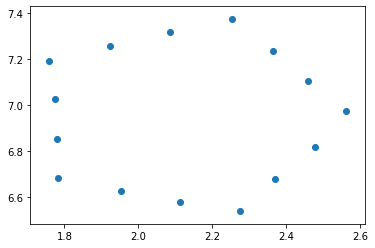

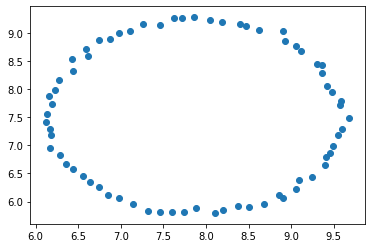

In [192]:
class ShapeGenerator(object):
    
    field_size = 10.
    
    def __init__(self):
        super(ShapeGenerator, self).__init__()

    def gen(self):
        self.x_center, self.y_center = np.random.uniform(size=2) * 0.6*self.field_size + 0.2*self.field_size
        self.size = np.random.uniform(0.02*self.field_size, 0.2*self.field_size)
        
    def plot_example(self):
        fig = plt.figure()
        ax = fig.gca()
        points = self.gen()        
        ax.scatter(points[0,:], points[1,:])
    

class PolygonShapeGenerator(ShapeGenerator):
    def __init__(self, n_sides=4):
        super(PolygonShapeGenerator, self).__init__()
        self.n_sides = n_sides
        
    def gen(self):
        super(PolygonShapeGenerator, self).gen()
        angle = np.random.uniform() * (2.*pi)/self.n_sides
        n_hits = int(7.*self.size)
        points = np.zeros((2, 0))
        
        for i_side in range(self.n_sides):
            x = (
                np.linspace(-0.5*self.size, 0.5*self.size, n_hits+1)[:-1]
                + np.random.normal(size=n_hits) * 0.01*self.size # Some noise
                )
            y = (
                np.random.normal(size=n_hits) * 0.01*self.size # Some noise
                - (0.5*self.size / np.tan(pi/self.n_sides))
                )
            v = np.stack((x,y))
            
            rot_angle = i_side * (2.*pi)/self.n_sides
            rot = np.array([
                [np.cos(rot_angle), -np.sin(rot_angle)],
                [np.sin(rot_angle), np.cos(rot_angle)],                
                ])
            
            v_rot = rot.dot(v)
            points = np.concatenate((points, v_rot), axis=1)
            
        global_rot = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)],                
            ])
        points = global_rot.dot(points)
        points[0,:] += self.x_center
        points[1,:] += self.y_center
        return points


class CircleShapeGenerator(ShapeGenerator):
    def gen(self):
        super(CircleShapeGenerator, self).gen()
        n_hits = int(40.*self.size)
        thetas = np.linspace(0., 2.*pi, n_hits+1)[:-1]
        x = np.cos(thetas) * self.size + self.x_center + np.random.normal(size=n_hits)*0.02*self.size
        y = np.sin(thetas) * self.size + self.y_center + np.random.normal(size=n_hits)*0.02*self.size
        return np.stack((x,y))
        
    
PolygonShapeGenerator(5).plot_example()
CircleShapeGenerator().plot_example()



In [199]:
class EventGenerator(object):
    
    def __init__(self):
        super(EventGenerator, self).__init__()
        self.triangle_generator = PolygonShapeGenerator(3)
        self.rectangle_generator = PolygonShapeGenerator(4)
        self.circle_generator = CircleShapeGenerator()
        self.n_noise = int(2. * 400)
        
    def gen(self):
        # Make noise hits
        n_noise = self.n_noise + int(np.random.normal(scale=80.))
        x_noise = np.random.uniform(size=n_noise) * ShapeGenerator.field_size
        y_noise = np.random.uniform(size=n_noise) * ShapeGenerator.field_size
        points = np.stack((x_noise, y_noise))
        labels = np.zeros(n_noise)
        
        def make_shape(shapegen, cat_number):
            n_shapes = max(int(4. + np.random.normal(scale=2)), 0)
            for i in range(n_shapes):
                new_points = shapegen.gen()
                new_labels = np.ones(new_points.shape[1]) * cat_number
                yield new_points, new_labels
                
        for i_cat, shapegen in enumerate(
            [ self.triangle_generator, self.rectangle_generator, self.circle_generator ]
            ):
            for new_points, new_labels in make_shape(shapegen, i_cat+1):
                points = np.concatenate((points, new_points), axis=1)
                labels = np.concatenate((labels, new_labels))
        
        return points, labels
    
    def plot_example(self):
        fig = plt.figure(figsize=(10,10))
        ax = fig.gca()
        
        points, labels = self.gen()
        cats = np.unique(labels)
        for cat in cats:
            points_in_cat = points[:,labels == cat]
            ax.scatter(points_in_cat[0], points_in_cat[1])
    

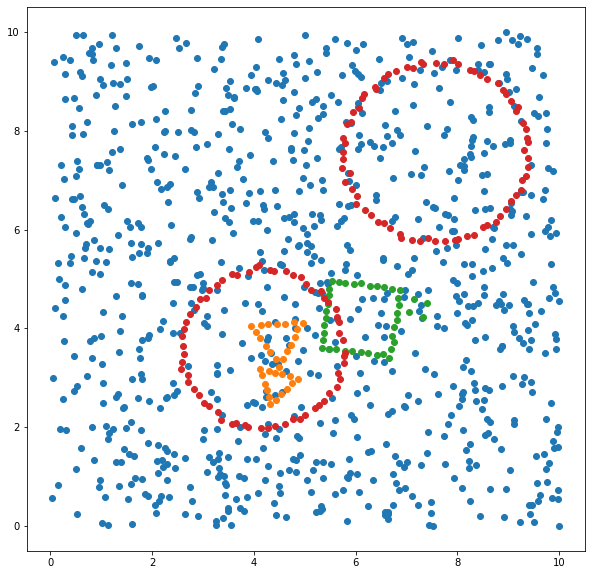

In [200]:
EventGenerator().plot_example()

In [202]:
class DatasetMaker(object):
    def make(self, n_events, directory):
        generator = EventGenerator()
        if not osp.isdir(directory): os.makedirs(directory)
        for i_event in tqdm((range(n_events))):
            outfile = osp.join(directory, '{0}.npz'.format(i_event))
            points, labels = generator.gen()
            np.savez(outfile, x=points, y=labels)        

In [203]:
DatasetMaker().make(10000, 'basicpoints')